Doing just some pure least square analysis.

Since our descritised generalised second order Lotka Volterra model is a linear map from $R^{1+2n}->R^n$, on which we can do least square analysis

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# First imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload
import sys # for reloading
import time
from scipy import stats # For the student t distribution
# import self made models
from LS_glv_minimal_code import * # generates Timeseries
from LS_gradient_descent import *# gradient descent algorithm
from LS_Functions import * # contains all important functions that were defined in week 2
import LS_SecOrderTimeseries
from scipy.stats import norm

Start with a simple time series and just do first basic LS and define the function that compute everything.

It took 3 attempts to find a stable state


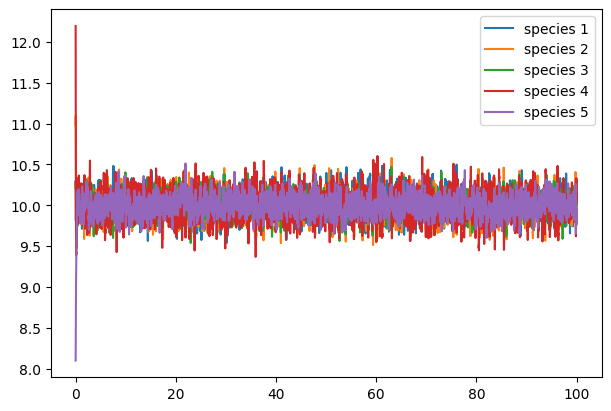

In [42]:
# generate a time series:
Timeseries = LS_SecOrderTimeseries.main(seed=1, noise=0.05, s1=0.05, s2=0.05, selfint=None, g_m=1, g_s=0.01, pertubation=0.1, period_pertu = 101)

Convert the timeseries to a numpy matrix with which we can work.

In [50]:
ts=Timeseries['timeseries'].values
ts.shape

(10000, 6)

The discrete lotka voltera model has the following form: $F=\theta Y$. Where theta are our model parameters. With this we are going to do a least square fit. In the note the model was noted as: $Y=\beta X$ so not to confuse it here. 

The result was that the least square fit is given by: $$\beta_{est}= YX^T(XX^T)^{-1}$$ For each row of the $\beta$ matrix. But one could just also immidiatly use the whole matrix $Y$ and get the result for the whole $\beta$. Since this is how matrix calculations works when $Y$ is on the far left. Since each row of $Y$ and thus each row of $\beta$ gets evaluated independtly in matrix calculation. 

Interesting to think about is how comes that optimising each row of matrix with LS is equivalant as minising the l_2 norm of the whole matrix. Try to find the connection between l_2 norm and LS. 

Next the variance of our $\beta$. Well this does have to be calculated for each row of the $\beta$. Since the variance of a vector results in the covariance matrix of that vector. Interestingly are the diagonal elements since these correspond to the variance of the row elements. 
Formula variance($\beta$):
$$var(\beta)= (XX^T)^{-1}*\sigma^2$$

Also interestingly from the covariance matrix of each row one can construct the correlation matrix of that row. -> We can vieuw the correlation between elements.

Sadly we actually don't have acces to $\sigma$. (we do but in reality we don't). So we estimate the $\sigma$ via:
$$ \sigma_{est}= \frac{1}{n-len(\beta.row)}\sum(y_i-y_{i est})^2$$
This would be a sigma estimate PER row. Since we also compute the variance per row. And else the test distribution does not match. 

So we now have:
$$var(\beta)_{est} = (XX^T)^{-1}*\sigma_{est}^2$$
And since $\sigma_{est}$ was computed using Stochatstic variables ($Y$). $Var(\beta)_{est}$ is also stochasticly distributed. (namely as a $\chi$-ish distribution) 

Next we do some Hypothesis test. There are two that we want to do:
1. Null hypothesis
2. Hypothesis agaisnt REAL ( this is just as a controll inorder to see if it estimates well)

When then compute a value:
$$ z_i = \frac{\beta_{i est}-\beta_{i hypo}}{[(XX^T)^{-1}]_{(i,i)}*\sigma_{est}^2}$$ 
Which will be distributed as a t-student distribution of a degree n-len($\beta.row$) **IF** the hypothesis is correct. However if it is not correct. Then we expect that $z_i$ be far of somewhere the t-student distribution is not likely at all. 

To quantify if our result is in a likely area of the t-student distr. and thus accept our hypothesis or reject it if it is some where not likely at all, we use a metric called the p-value. This p-value is an area under the t-distribution curve starting from our measured $z_i$. If this is VERY VERY low, meaning that our $z_i$ landed somewhere where the t-student distr. is not likely at all. We reject our hypothesis else we accept it. 

----

To summarise what we need for our analysis here:
1. Compute $F$ and $Y$ (being actually $X$ in the notation above) from our timeseries.
2. Estimate the parameters $\theta$ via least-square (LS) with the formula: $\theta_{est}=FY^T(YY^T)^{-1}$ 
3. Compute $F_{est}$ being now our estimate of $F$ given our $\theta_{est}$. This is used in the next calculation:
4. For each row of $\theta_{est}$ estimate the variance of the error term via formula: $\sigma_{row=j,est}= \frac{1}{n-len(\theta.row)}\sum(F_i-F_{i est})^2$ 
5. Now compute the estimated variance of each row j of $\theta$ via: $var(\theta)_{est}=(YY^T)^{-1}*\sigma_{row=j,est}^2$. 
6. Now for each Hypothesis and each row compute for the i'th element in the row: $z_{row=j,col=i} = \theta_{row=j,col=i,est}-\theta_{row=j,col=i,hypo}/[var(\theta_{row=j})]_{(i,i)}$. Basicly construct this way an matrix Z
7. For this matrix Z-compute the p-value. 

Interestingly to note. In point 5, the variance of a row of $\theta$ does not depend on a row of $F$. So it would be the same everytime!! The dependene is hidden away in the $\sigma_{row=j,est}$ which uses row i of $F$, but we expect it to be the same for all rows... Does this makes sense, was there a mistake some where? 

In [51]:
# Point 1 Compute F and Y given the time series
def F(timeseries):
    # Timeseries is  expected to be a numpy with where rows are the observations, First column is the timeseries points and subsequent columns the abundancy of a species.
    
    ts = timeseries[:,1:].T # Remove the first column since it is the time, transpose so that time is now the column
    dt = np.diff(timeseries[:,0])# compute the difference in time points
    # Compute the log difference and return the change per time. 
    dln = np.diff(np.log(ts))
    return dln/dt


def Y_second(timeseries):
    # When computing Y we want to know what kind of parameters we want to infer.
    # This funciton infers the parameters of the a second order descritesed Generalised Lotka Voltera model
    
    # For second order data matrix Y, we need three parts: The growth rate, just the timeseries and the squared timeseries
    ts = timeseries[:,1:].T # acquire timeseries
    ts2 = np.power(ts,2)
    grow = np.ones([1, ts.shape[1]])
    
    # Append them
    Y_all = np.append(grow,ts,axis=0)
    Y_all = np.append(Y_all,ts2, axis=0)
    return np.delete(Y_all, -1, axis = 1) # return with the last element removed. Else dimension do not match since F takes a difference

F_ts=F(ts)
print(F_ts.shape)
Y_ts=Y_second(ts)
print(Y_ts.shape)

(5, 9999)
(11, 9999)


In [52]:
# Point 2 Compute the least square estimate of the parameter matrix theta.
def LS_estimate(F,Y):
    YYT =     np.dot(Y,Y.T)
    inv_YYT = np.linalg.inv(YYT)
    FYT =     np.dot(F,Y.T)
    return np.dot(FYT,inv_YYT)

theta_est=LS_estimate(F_ts,Y_ts)
print(theta_est.shape)

(5, 11)


In [53]:
# Point 3 Compute F based on our estimate of theta_est
def F_est(theta_est,Y):
    return np.dot(theta_est,Y)

F_ts_est = F_est(theta_est,Y_ts)
print(F_ts_est.shape)

(5, 9999)


In [54]:
# Point 4 Compute the estimated sigma for each row. 
def Sigma_est(F,F_est,len_theta_row):
    n_obser = F.shape[1]
    norm_factor = np.power(float(n_obser-len_theta_row),-1)
    diff_square = np.power(F-F_est,2)
    return norm_factor*np.sum(diff_square,axis=1) # axis 1 is the row 

sigma_est = Sigma_est(F_ts,F_ts_est,theta_est.shape[1])
print(sigma_est.shape)

(5,)


In [55]:
# Point 5, Compute estimated variance/ covariance for each row of theta
def Covariance_Tensor_est(Y,sigma_est):
    # Computes the covariance matrix for each row off theta. Store this in a three dimensional tensor.
    # First index is the index for the covariance matrix. Indexes after that are that of the matrix itself.
    
    len_Covar = Y.shape[0]
    inv_YYT= np.linalg.inv(np.dot(Y,Y.T))
    
    for i, sigma_row in enumerate(sigma_est):
        Covar = inv_YYT*sigma_row
        Covar = Covar.reshape((1,len_Covar,len_Covar)) # Make it third order tensor. In order to append it to the All_Covar tensor
        All_Covar = np.append(All_Covar,Covar,axis=0) if i!=0 else Covar # In the first loop All_Covar is the third tensor Covar itself. 
    
    return All_Covar

Cov_Tensor_est = Covariance_Tensor_est(Y_ts,sigma_est)
print(Cov_Tensor_est.shape)

(5, 11, 11)


In [56]:
# Point 6 compute the matrix Z for a given hypthesis. 
def Z_hypo(theta_hypo, theta_est, Cov_Tensor_est):
    diff_theta = theta_est-theta_hypo
    var_theta = Cov_Tensor_est.diagonal(offset=0,axis1=1,axis2=2)# We need to take the diagonal of each matrix, which were the indexes on axis 1&2
    return diff_theta/np.sqrt(var_theta)

Z_nullhypo = Z_hypo(np.zeros(shape=theta_est.shape) ,theta_est, Cov_Tensor_est)
print(f"Z_nullhypo.shape={Z_nullhypo.shape}")

def Theta_real(data): # Where data is the dictionary that was returned when running the timeseries generation function
    # Extract the correct matrixes
    r = data['growthrate'] # shape (n,1)
    a = data['allee_factor'] # shape (n,1)
    d = data['immigration_rate'] # shape (n,1)
    B = data['Interaction_Matrix'] # shape (n,n)
    C = data['SecondOrder_matrix'] # shape (n,n)
    
    # define mu, M and N
    mu = r*a-d
    M = B*r.reshape([1,r.shape[0]])
    N = C*r.reshape([1,r.shape[0]])
    # append them and return
    Theta = np.append(mu, M, axis=1)
    Theta = np.append(Theta, N, axis=1)
    return Theta

theta_real = Theta_real(Timeseries)
Z_realhypo = Z_hypo(theta_real, theta_est, Cov_Tensor_est)
print(f"Z_realhypo.shape={Z_realhypo.shape}")

Z_nullhypo.shape=(5, 11)
Z_realhypo.shape=(5, 11)


In [57]:
# Point 7, Compute the p-value of the Z-matrix

def P_value(Z_matrix, t_student_df):
    p = 2*(1 - stats.t.cdf(np.abs(Z_matrix),df=t_student_df))# make sure to "from scipy import stats"
    return p

#def cP_value(Z_matrix, t_student_df):
#    p = stats.t.cdf(Z_matrix,df=t_student_df)# make sure to "from scipy import stats"
#    return p

def DF(Y): # returns the degree of freedom used for the t_student distribution
    theta_row, n_obser = Y.shape
    return n_obser-theta_row

p_nullhypo = P_value(Z_nullhypo,DF(Y_ts))
print(p_nullhypo.shape)
p_realhypo = P_value(Z_realhypo,DF(Y_ts))
print(p_realhypo.shape)
#cp_nullhypo = cP_value(Z_nullhypo,DF(Y_ts))
#print(cp_nullhype.shape)
#cp_realhypo = cP_value(Z_realhypo,DF(Y_ts))
#print(cp_realhypo.shape)

(5, 11)
(5, 11)


-------
Now that everything is calculated. Time to look at the results and make sure they make sense, else there is some debugging needed. 


In [64]:
# Calculate the difference theta_est and real theta, And make tha absolute. 
plotM(np.log10(np.abs(theta_real),"Real theta",mode="PosNeg")
plotM(theta_est,"Least Square theta",mode="PosNeg")

def MError(M1,M2):
    return np.abs(M1-M2)
def MRelError(M,Mref):
    return np.abs(M-Mref)/abs(Mref)

# plot relatif difference:
plotM(MRelError(theta_est,theta_real)," Relatif error of LS estimated error")

SyntaxError: invalid syntax (<ipython-input-64-b99f4220cfed>, line 3)

So we see the following the errors are high and the infered theta does not look at all like what we need to get. But this result should be reflected with the p-value.

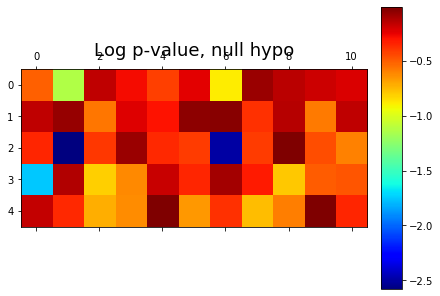

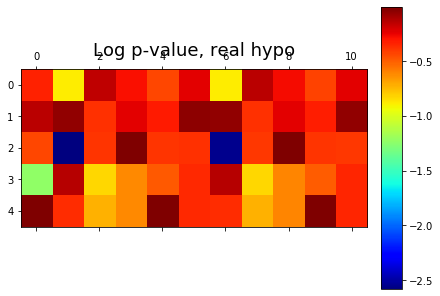

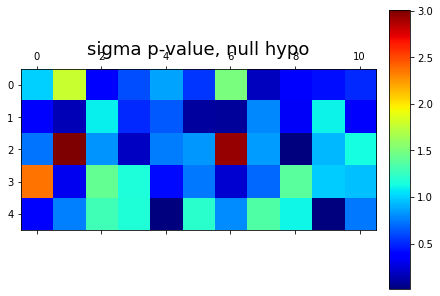

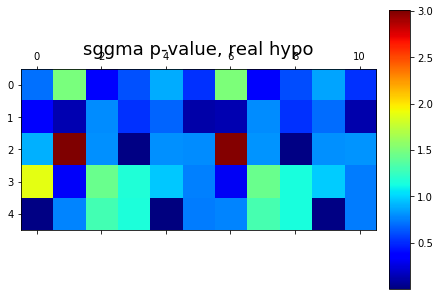

In [59]:
# p-value research
plotM(np.log10(p_nullhypo), "Log p-value, null hypo")
plotM(np.log10(p_realhypo), "Log p-value, real hypo")
# Using sigma's
plotM(abs(norm.ppf(p_nullhypo/2)), "sigma p-value, null hypo")
plotM(abs(norm.ppf(p_realhypo/2)), "sggma p-value, real hypo")
#plotM(np.log10(cp_nullhypo), "Log cp-value, real hypo")
#plotM(np.log10(cp_realhypo), "Log cp-value, real hypo")

One can read this as follows: Notice that the smallest value is $\pm$ -2, meaning a smalles p-value of $10^{-2}= 0.01$ . Meaning if we would do the measurment agian but with a different seed. We would have 1% chance that the result would be worse off. 

This is pushing the boundries. But to put it in sigma's away in a normaldistrbution interpretation this would still be under 3 $\sigma$ away. P-value at 3 $\sigma$=0.13%=-2.88. This is within perfect accaptable range. 

Basicly -2, means roughly a 1/100 chance, We have here 55 variables, so the chance to draw something 1/100 is perfectly in possible range. On top of this that the majority is in the range [-0.05,0.75] -> p=[0.89,0.17]. We can with comfort say that the hypothesis is accepted. 

**We should maybe aply the look else were effect !!** When viewing many parameters, then it is normal that we draw an 1/100 chances. 

But this is now the case for both hypothesises. Eventhough the absolute and relatif error was far off. It is all in acceptable range of the variance. So the variance is probabily huge, compared to the absolute error, allowing. 

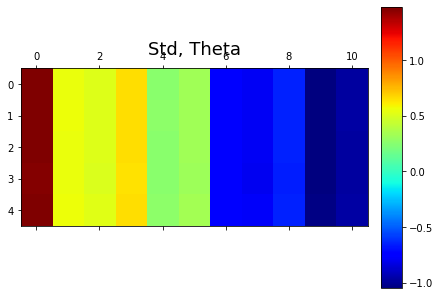

In [61]:
# have a look at the standard deviation:
var_theta = Cov_Tensor_est.diagonal(offset=0,axis1=1,axis2=2)
std_theta = np.sqrt(var_theta)
plotM(np.log10(std_theta),"Std, Theta")

We have this weird, stripe effect. This what I said that there is no F dependence in the formula of variance estimation, resulting in the stripes. 

And now we also see why we had an "outlier", in the p-value plot. LS estimated that the parameter is to be 13, while the real one is nearly 0. But our std is like 7, so we are even within the 2 sigma range. Perfectly normal. 

Another weird result of from the plot above... The variance of the second order is better. Actually probably **sqrt** better, because how $Y$ is constructed, and the resulting $(YY^T)^{-1}$. Actually this has some weird reasoningn that the infinit order has variance zero, meaning we are really certain about the prediction... This makes no sense. 

----
In order to descriminate the Real hypothesis from the Null hypothesis, the standard deviation of the estimated theta should be atleast of the same order as the difference between the hypothesis. In this case just the real theta. 

Let's have a look at it. Note that in reality theta_real is not avaibable to us. So we wouldn't be able to make the following plot. 

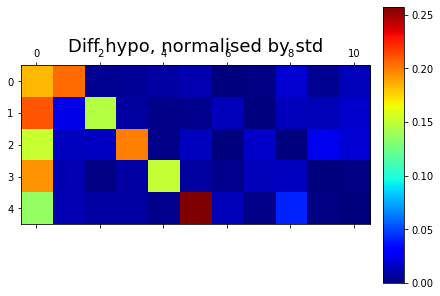

In [15]:
plotM(abs(theta_real)/std_theta,"Diff hypo, normalised by std")

Note we want this to be 1 before we would be able to discriminate between the two hypothesis and tell which one is real. We see this is only healty in the cases where absolute order of theta_real is of order 1, while the other is really bad.

-> This highlights the importance that enormous magnitude difference in the parameters in the can result in really bad fit. Since the variance will be roughly on the same order accross the board, hence the parameters who are a couple of magnitudes below.

The best that we can do now is 0.25. But even this is not enough to discriminate. To be certain that a parameters can be trusted, then we should have atleast =3. So our std needs to be atleats 12 times better, or basicly more then a full magnitude, before we can destinguish the nullhypothesis from the real. And this is already for the parameters with the highest orders... for the others there is no hope. 

--------

Things to further do:
1. Litterly redo the same analsyis above, but take a different seed.
2. Check for other configurations of the Generalised Model. Try to find theta's which parameters are all of the same order
3. Take a look at the covariance matrix. And actually take a look at the correlation matrix.
4. Try to understand why there is no F dependecy in the variance calculations. Try to make sense of this, because the theory predicts that every correlation matrix and all the covariance matrix of each row are the same.
5. Try to have a looks else where effects. Such that these outliers are less common.
6. Make a plot that works with sigma's away. In stead of log10(p)
7. Look at the distribution of the Z matrix elements. These should form a t-student distribution. (Or basicly gaussian for us)
8. Implement the inverse p-value, we now only look at one side.. and don't look at outliers of the other side. 

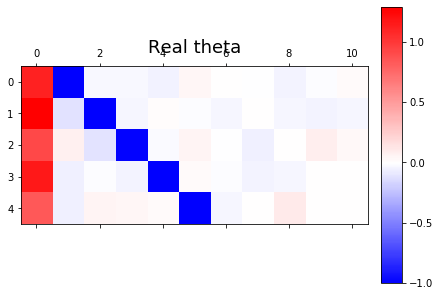

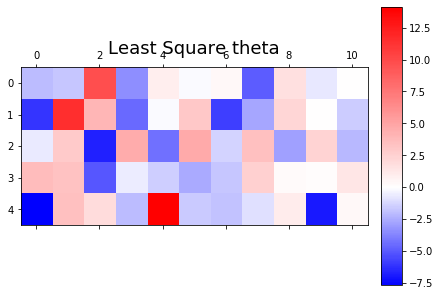

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


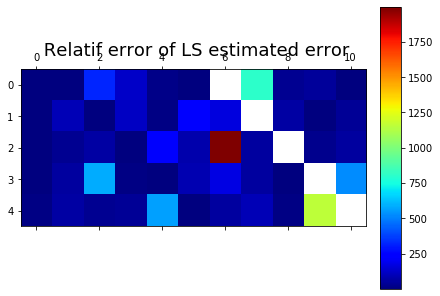

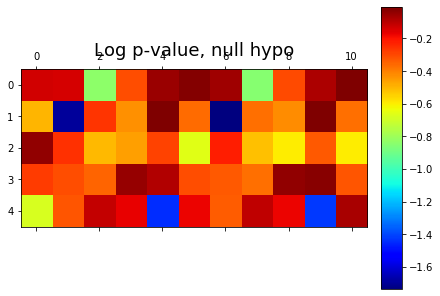

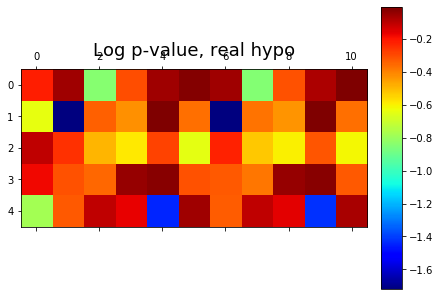

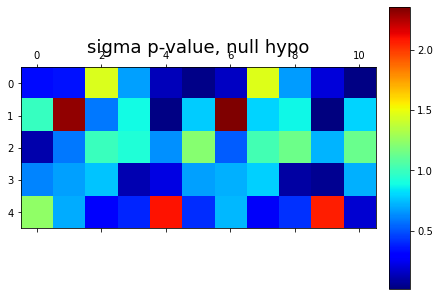

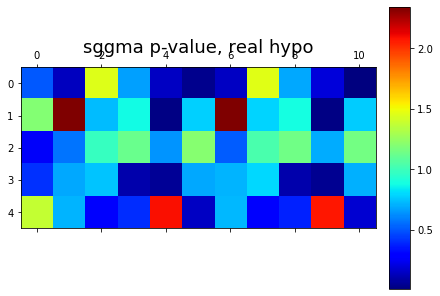

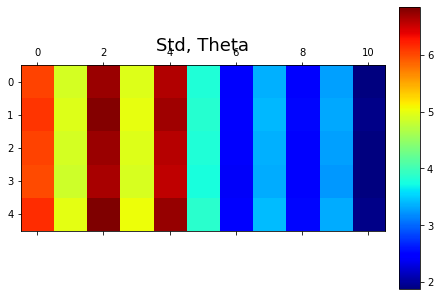

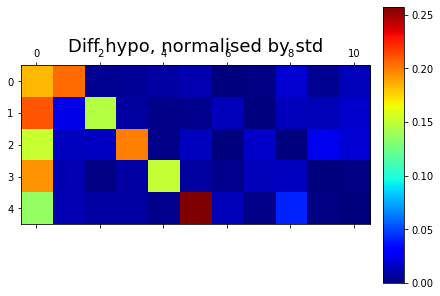

In [38]:
def LeastSquareAnalysis(timeseries):
    ts = timeseries['timeseries'].values
    F_ts=F(ts)
    Y_ts=Y_second(ts)
    
    theta_est=LS_estimate(F_ts,Y_ts)
    F_ts_est = F_est(theta_est,Y_ts)
    sigma_est = Sigma_est(F_ts,F_ts_est,theta_est.shape[1])
    Cov_Tensor_est = Covariance_Tensor_est(Y_ts,sigma_est)
    
    Z_nullhypo = Z_hypo(np.zeros(shape=theta_est.shape) ,theta_est, Cov_Tensor_est)
    theta_real = Theta_real(timeseries)
    Z_realhypo = Z_hypo(theta_real, theta_est, Cov_Tensor_est)
    
    p_nullhypo = P_value(Z_nullhypo,DF(Y_ts))
    p_realhypo = P_value(Z_realhypo,DF(Y_ts))
    
    var_theta = Cov_Tensor_est.diagonal(offset=0,axis1=1,axis2=2)
    std_theta = np.sqrt(var_theta)
    
    # plot:
    plotM(theta_real,"Real theta",mode="PosNeg")
    plotM(theta_est,"Least Square theta",mode="PosNeg")
    plotM(MRelError(theta_est,theta_real)," Relatif error of LS estimated error")
    
    plotM(np.log10(p_nullhypo), "Log p-value, null hypo")
    plotM(np.log10(p_realhypo), "Log p-value, real hypo")
    
    plotM(abs(norm.ppf(p_nullhypo/2)), "sigma p-value, null hypo")
    plotM(abs(norm.ppf(p_realhypo/2)), "sggma p-value, real hypo")
    
    plotM(std_theta,"Std, Theta")
    plotM(abs(theta_real)/std_theta,"Diff hypo, normalised by std")
    
    output = {"theta_est":theta_est, "theta_real": theta_real, "p_nullhypo":p_nullhypo, "p_realhypo":p_realhypo, "Cov_Tensor_est": Cov_Tensor_est}
    return output

result = LeastSquareAnalysis(Timeseries)

It took 10 attempts to find a stable state


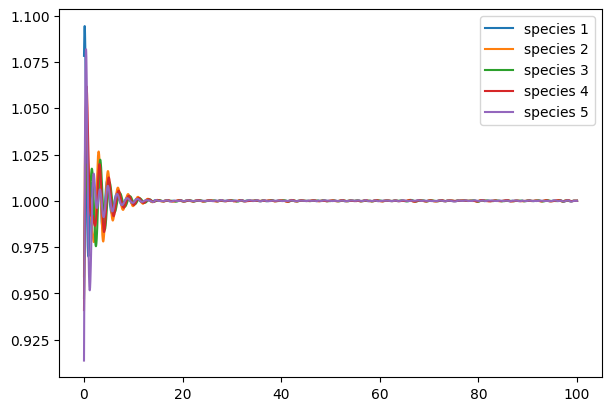

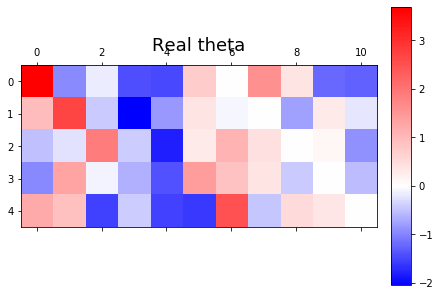

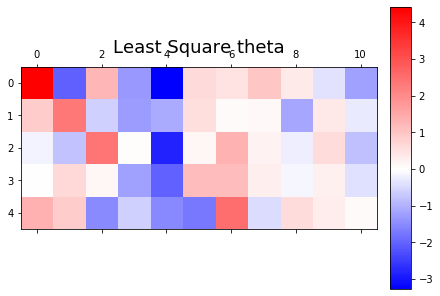

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


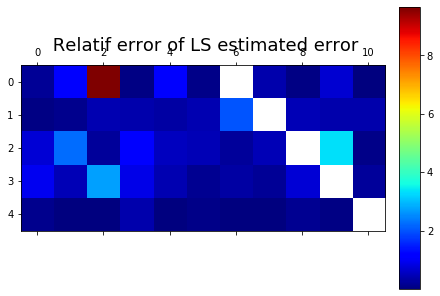

/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


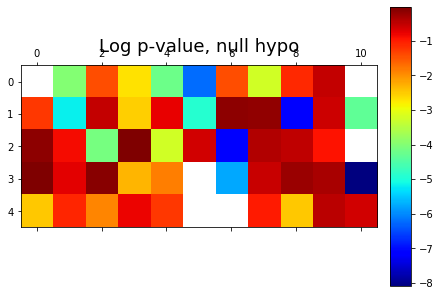

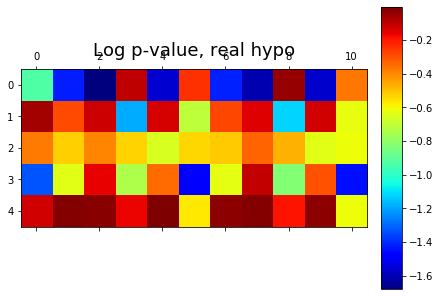

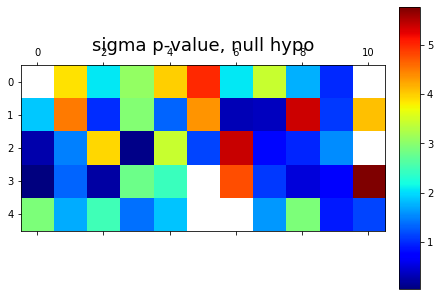

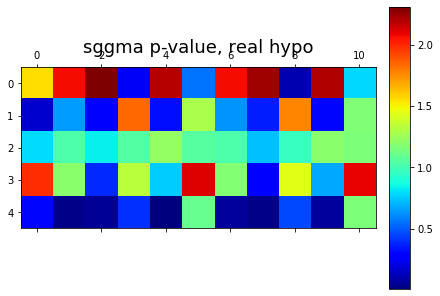

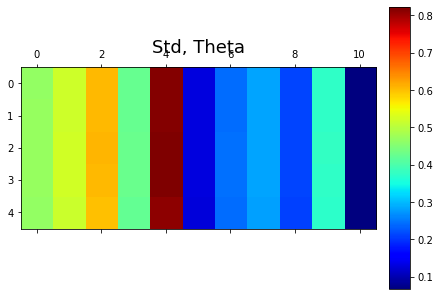

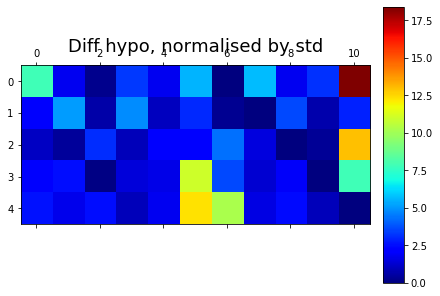

In [39]:
Better_TS = LS_SecOrderTimeseries.main(seed=2, noise=0.0001, s1=1, s2=1, selfint="Keystone", g_m=1, g_s=0.01, pertubation=0.1,period_pertu = 101)
restult =  LeastSquareAnalysis(Better_TS)

------
Construct a complementary p-test

In [1]:
def cP_value(Z_matrix, t_student_df):
    p = stats.t.cdf(Z_matrix,df=t_student_df)# make sure to "from scipy import stats"
    return p